In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
# Unzip the downloaded file
!unzip -q /content/drive/MyDrive/PlantVillage.zip

# Import Libraries

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Load Data

In [ ]:
#Organizing the dataset
data_dir = '/content/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

import json

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
included_subdirs = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
image_datasets = {}
for x in ['train', 'val']:
    dir_path = os.path.join(data_dir, x)
    included_paths = [os.path.join(dir_path, subdir) for subdir in included_subdirs]
    dataset = datasets.ImageFolder(dir_path, transform=data_transforms[x])

    # Filter samples and update class indexing
    filtered_samples = [
        (path, class_idx)
        for path, class_idx in dataset.samples
        if os.path.dirname(path) in included_paths
    ]
    if len(filtered_samples) == 0:
        raise ValueError(f"No samples found in the included subdirectories for '{x}' split.")

    filtered_paths, filtered_targets = zip(*filtered_samples)
    unique_targets = sorted(set(filtered_targets))
    target_mapping = {class_idx: i for i, class_idx in enumerate(unique_targets)}

    filtered_targets = [target_mapping[class_idx] for class_idx in filtered_targets]
    dataset.samples = list(zip(filtered_paths, filtered_targets))
    dataset.targets = filtered_targets
    dataset.classes = [dataset.classes[class_idx] for class_idx in unique_targets]

    image_datasets[x] = dataset

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [ ]:
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
dataset_sizes

{'train': 14529, 'val': 3631}

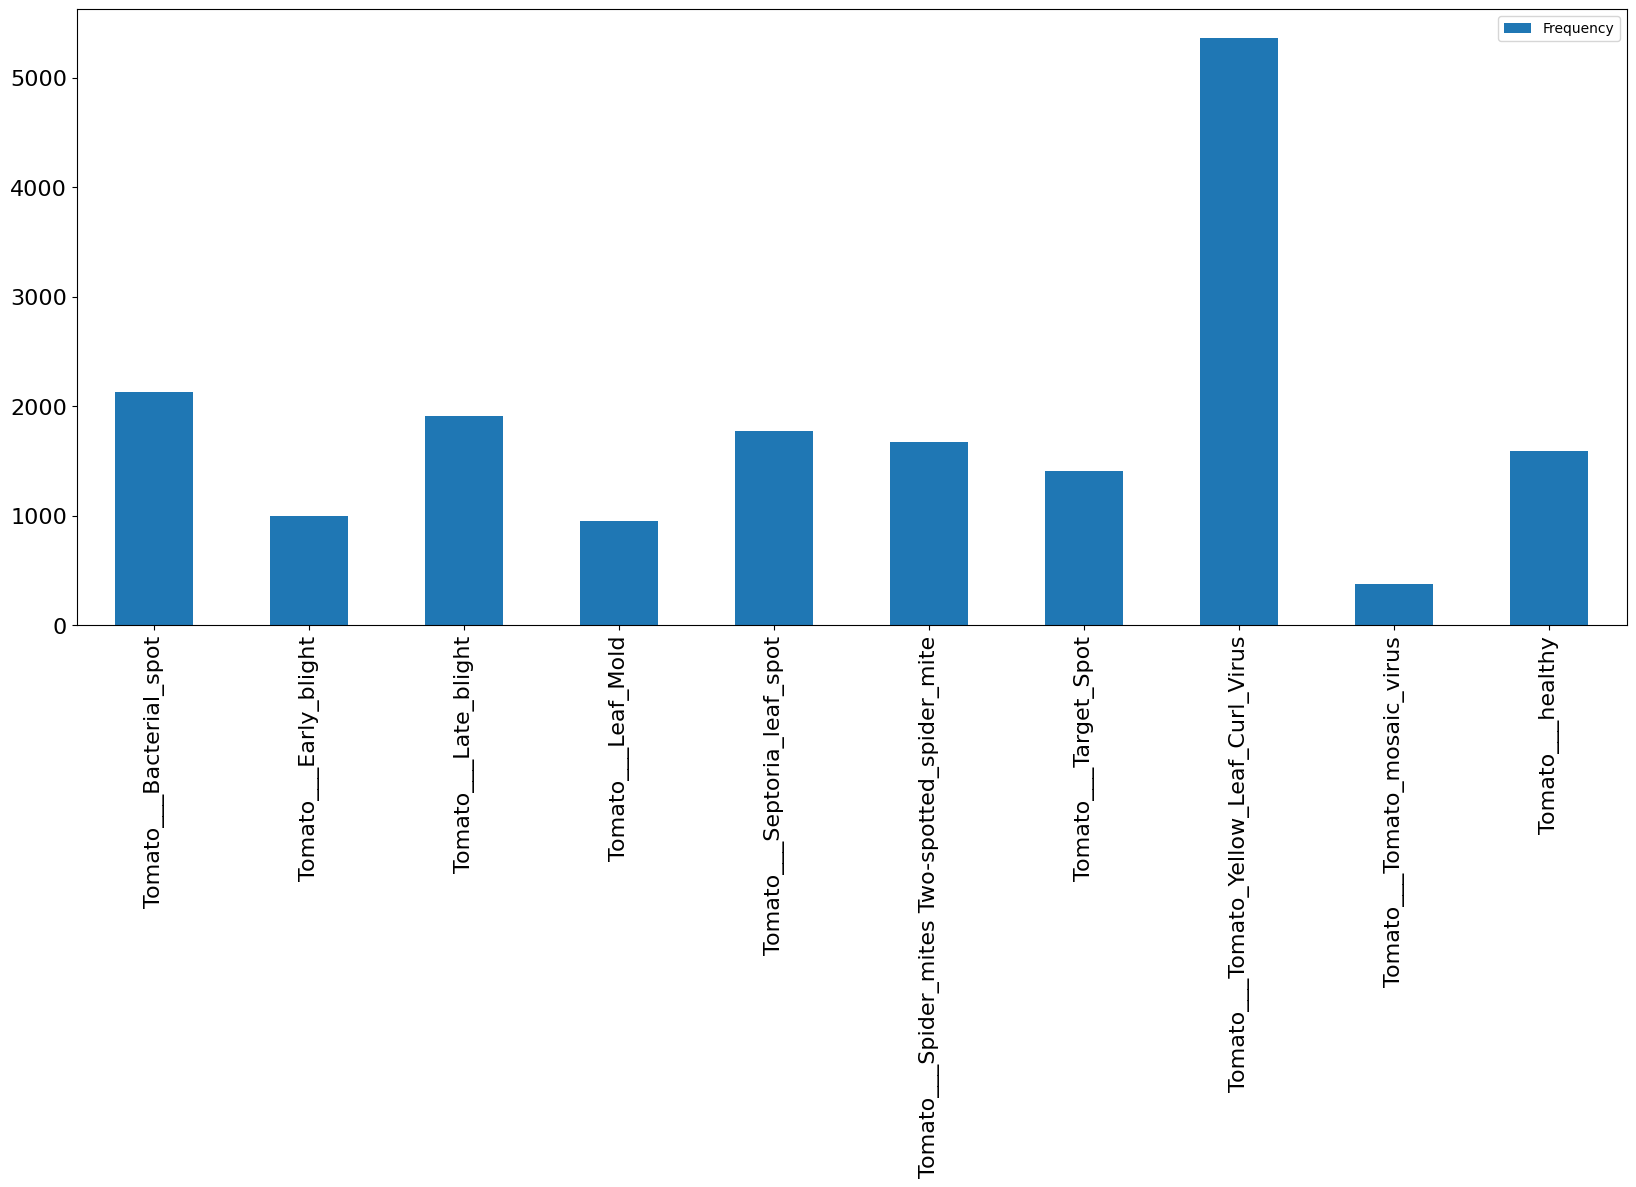

In [ ]:
from collections import Counter
import pandas as pd

counts = Counter(image_datasets['train'].targets)
df = pd.DataFrame(columns=['Frequency'])

for i in counts:
    df.loc[class_names[i]] = counts[i]

counts = Counter(image_datasets['val'].targets)

for i in counts:
    df.loc[class_names[i]] = df.loc[class_names[i]] + counts[i]

df.plot.bar(figsize=(20, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Train

## Load Pre-Trained Model

In [ ]:
# model = models.resnet152(pretrained=True)
model = models.densenet121(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.6MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Train Model

In [ ]:
from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.classifier = classifier

#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train a model with a pre-trained network
import time

num_epochs = 20
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

training_start_time = time.time()
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Using GPU: True
Epoch 1/20
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7502 Acc: 0.7527
val Loss: 0.4412 Acc: 0.8460

Epoch 2/20
----------
train Loss: 0.5214 Acc: 0.8269
val Loss: 0.2615 Acc: 0.9185

Epoch 3/20
----------
train Loss: 0.4454 Acc: 0.8466
val Loss: 0.6231 Acc: 0.7940

Epoch 4/20
----------
train Loss: 0.4441 Acc: 0.8491
val Loss: 0.5106 Acc: 0.8177

Epoch 5/20
----------
train Loss: 0.3482 Acc: 0.8815
val Loss: 0.2615 Acc: 0.9039

Epoch 6/20
----------
train Loss: 0.3275 Acc: 0.8878
val Loss: 0.2472 Acc: 0.9105

Epoch 7/20
----------
train Loss: 0.3217 Acc: 0.8896
val Loss: 0.2383 Acc: 0.9102

Epoch 8/20
----------
train Loss: 0.3162 Acc: 0.8929
val Loss: 0.3577 Acc: 0.8711

Epoch 9/20
----------
train Loss: 0.3237 Acc: 0.8919
val Loss: 0.2223 Acc: 0.9188

Epoch 10/20
----------
train Loss: 0.3055 Acc: 0.8957
val Loss: 0.2303 Acc: 0.9146

Epoch 11/20
----------
train Loss: 0.2972 Acc: 0.8987
val Loss: 0.2768 Acc: 0.9028

Epoch 12/20
----------
train Loss: 0.3037 Acc: 0.8983
val Loss: 0.2449 Acc: 0.9127

Epoch 13/20
----------


In [ ]:
# Size and number of parameters of model
param_size = 0
num_parameters = 0
for param in model.parameters():
    num_parameters += 1
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('number of parameters: '+ str(num_parameters))

model size: 28.868MB
number of parameters: 366


# Test Model

In [ ]:
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0

  model.to(device)

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)

    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

In [ ]:
test(model, dataloaders, device)

Testing Accuracy: 0.995


# Save Model

In [ ]:
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/DDP/Saved Models/plantvillage_tomato_densenet.pth')

# Save Model as H5

In [ ]:
torch.save(model, '/content/drive/MyDrive/DDP/Saved Models/plantvillage_tomato_densenet.h5')

In [ ]:
loaded_model_h5 = torch.load('/content/drive/MyDrive/DDP/Saved Models/plantvillage_tomato_densenet.h5')

In [ ]:
test(loaded_model_h5, dataloaders, device)

Testing Accuracy: 0.928


# GradCAM Visualisation

In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1115, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1115 (delta 4), reused 11 (delta 3), pack-reused 1097
Receiving objects: 100% (1115/1115), 110.17 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [ ]:
import sys

sys.path.append('/content/pytorch-grad-cam')

In [ ]:
!pip install -r pytorch-grad-cam/requirements.txt

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
loaded_model_h5=model

In [ ]:
print(loaded_model_h5)

In [ ]:
# Layer name of each layer, used for deciding which layer to freeze
for name, module in loaded_model_h5.named_modules():
    print(name)

# Decide which layer to freeze


net
net.features
net.features.conv0
net.features.norm0
net.features.relu0
net.features.pool0
net.features.denseblock1
net.features.denseblock1.denselayer1
net.features.denseblock1.denselayer1.norm1
net.features.denseblock1.denselayer1.relu1
net.features.denseblock1.denselayer1.conv1
net.features.denseblock1.denselayer1.norm2
net.features.denseblock1.denselayer1.relu2
net.features.denseblock1.denselayer1.conv2
net.features.denseblock1.denselayer2
net.features.denseblock1.denselayer2.norm1
net.features.denseblock1.denselayer2.relu1
net.features.denseblock1.denselayer2.conv1
net.features.denseblock1.denselayer2.norm2
net.features.denseblock1.denselayer2.relu2
net.features.denseblock1.denselayer2.conv2
net.features.denseblock1.denselayer3
net.features.denseblock1.denselayer3.norm1
net.features.denseblock1.denselayer3.relu1
net.features.denseblock1.denselayer3.conv1
net.features.denseblock1.denselayer3.norm2
net.features.denseblock1.denselayer3.relu2
net.features.denseblock1.denselayer3.co

In [ ]:
freeze_layers = ["features.denseblock4.denselayer16.conv2"]
# Output Layer name for which training is ON
for name, parameter in loaded_model_h5.named_parameters():
  if any(freeze_layer in name for freeze_layer in freeze_layers):
    parameter.requires_grad = True
    print(name)

features.denseblock4.denselayer16.conv2.weight


In [ ]:
target_layers = [loaded_model_h5.features.denseblock4.denselayer16.conv2]

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.

    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]

    imgA = (imgA - 0.485)/(0.229)
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)

    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC

    npImage = np.transpose(npImage, (2,0,1))

    return npImage

<ipython-input-39-59e2a99597f7>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(size, Image.ANTIALIAS)
<ipython-input-40-a3a37c495027>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])


torch.Size([1, 3, 224, 224])


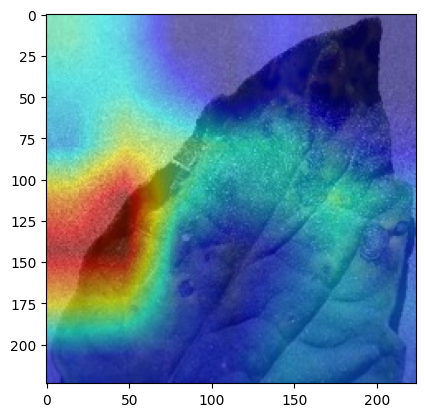

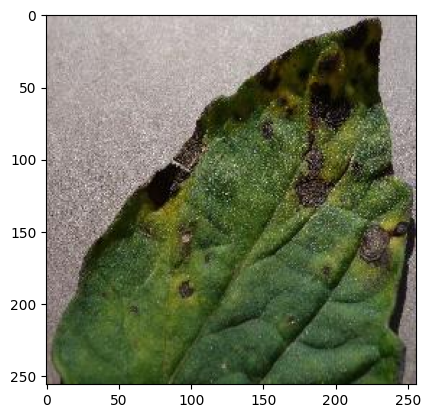

In [ ]:
image_path = '/content/PlantVillage/train/Tomato___Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers, use_cuda=True)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


<ipython-input-15-59e2a99597f7>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(size, Image.ANTIALIAS)


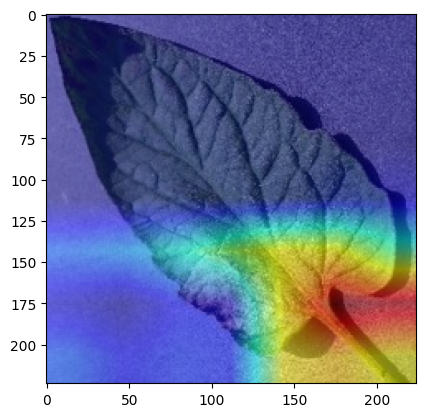

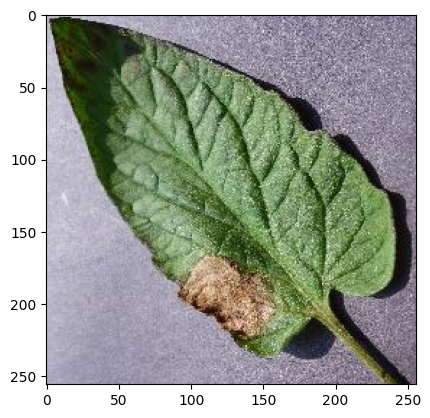

In [ ]:
image_path = '/content/PlantVillage/val/Tomato___Late_blight/f8176522-163b-48ee-a1a2-ea94c782b4ad___RS_Late.B 6137.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers, use_cuda=True)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

<ipython-input-15-59e2a99597f7>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(size, Image.ANTIALIAS)
<ipython-input-16-5ce0950e141c>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])


torch.Size([1, 3, 224, 224])


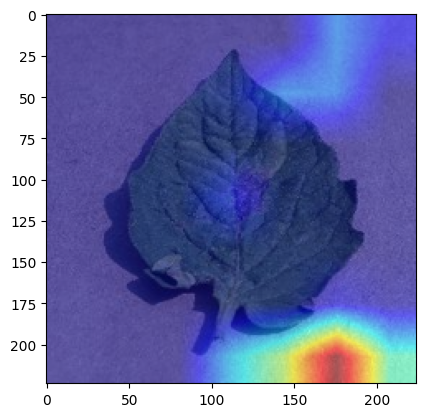

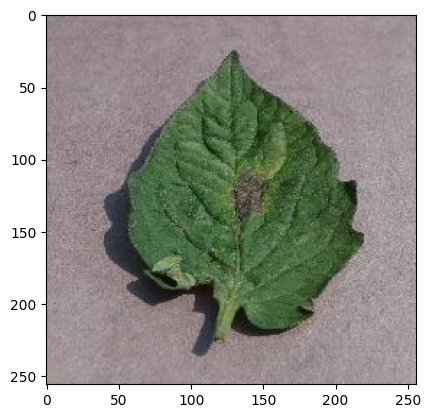

In [ ]:
image_path = '/content/PlantVillage/val/Tomato___Late_blight/f33028e4-68df-4312-ba25-94d65f03efcf___RS_Late.B 5530.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers, use_cuda=True)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


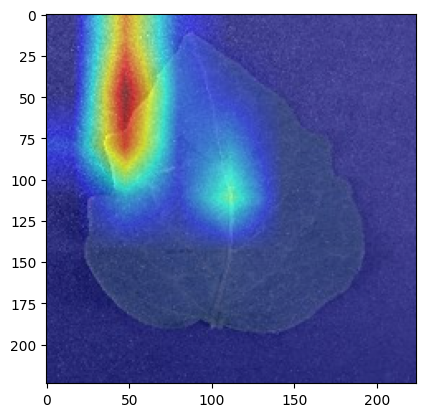

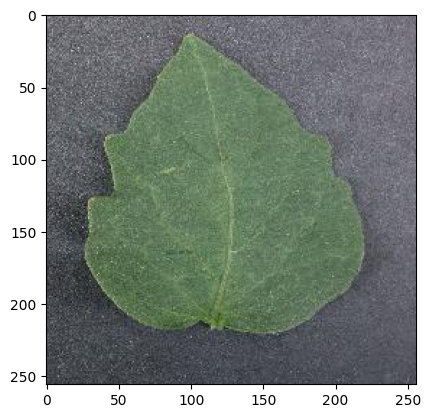

In [ ]:
image_path = '/content/PlantVillage/train/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers, use_cuda=True)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

# TSNE plots



In [ ]:
# weighted sampling
wt_samp = False
if wt_samp:
    class_counts = pd.DataFrame(image_datasets['train'].targets).value_counts()
    class_wt = [1/class_counts[i] for i in image_datasets['train'].targets]

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=class_wt, num_samples=len(image_datasets['train']), replacement=True
        )
    dataloaders = {}
    dataloaders['val'] = torch.utils.data.DataLoader(
        image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=2
        )
    dataloaders['train'] = torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=batch_size, sampler=sampler
        )
else:
    # Using the image datasets and the trainforms, define the dataloaders
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=2)
                  for x in ['train', 'val']}

In [ ]:
model = loaded_model_h5

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

model = model.cuda()
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
features = None
labels = None
for images, label in dataloaders['val']:
    images = Variable(images)
    label = Variable(label)
    images, label = images.to(device), label.to(device)

    with torch.no_grad():
        output = model.forward(images)

    current_features = output.cpu().numpy()
    current_labels = label.cpu().numpy()
    if features is not None:
        features = np.concatenate((features, current_features))
        labels = np.concatenate((labels, current_labels))
    else:
        features = current_features
        labels = current_labels

print("Got features")
print("Features shape:", features.shape)

Got features
Features shape: (3631, 10)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(features)
print("Fitted TSNE")

Fitted TSNE


In [ ]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

TSNE plot using the full model 'features' block and 'classifier' block

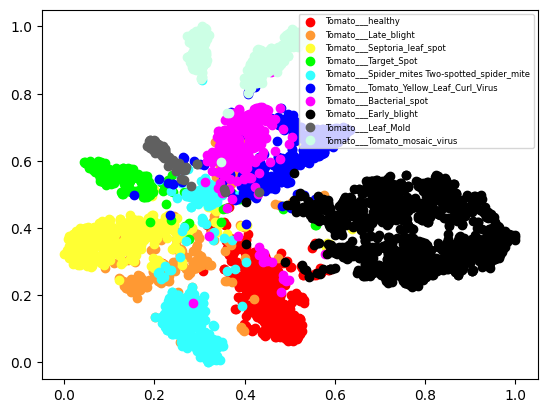

In [ ]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
colors_per_class = {
    0 : [255, 0, 0],
    1 : [255, 153, 51],
    2 : [255, 255, 51],
    3 : [0, 255, 0],
    4 : [51, 255, 255],
    5 : [0, 0, 255],
    6 : [255, 0, 255],
    7 : [0, 0, 0],
    8 : [96, 96, 96],
    9 : [204, 255, 229]
}
classes = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float32) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, color=color, label=classes[label])
# build a legend using the labels we set previously
ax.legend(loc='best', prop={'size': 6})

In [ ]:
for name, _ in model.named_modules():
    print(name)

In [ ]:
print(model)

In [ ]:
import torch
import numpy as np

features = None
labels = None

def hook(module, input, output):
    global features
    global labels

    current_features = torch.mean(output, dim=(2, 3)).cpu().numpy()  # Apply global average pooling to reduce spatial dimensions
    current_labels = label.cpu().numpy()

    if features is not None:
        features = np.concatenate((features, current_features))
        labels = np.concatenate((labels, current_labels))
    else:
        features = current_features
        labels = current_labels

# Register a forward hook to capture the output of the desired layer
# desired_layer = model._modules.get("features")._modules.get("denseblock4")._modules.get("denselayer16")._modules.get("conv2")
desired_layer = model._modules.get("features")
hook_handle = desired_layer.register_forward_hook(hook)

# Loop over the validation data
for images, label in dataloaders['val']:
    images = images.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model.forward(images)

# Remove the hook after extracting the features
hook_handle.remove()

# Print the shape of the features
print("Features shape:", features.shape)

Features shape: (3631, 1024)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(features)
print("Fitted TSNE")

Fitted TSNE


TSNE plot using 'features' block


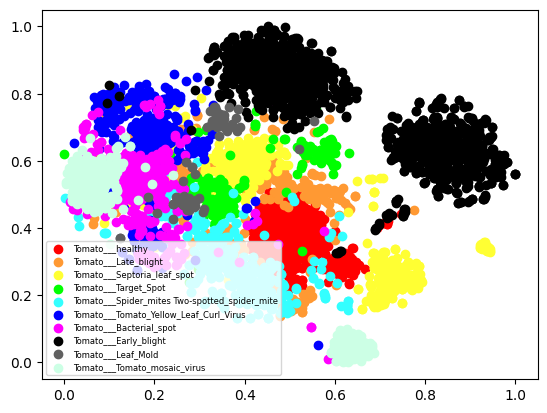

In [ ]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
colors_per_class = {
    0 : [255, 0, 0],
    1 : [255, 153, 51],
    2 : [255, 255, 51],
    3 : [0, 255, 0],
    4 : [51, 255, 255],
    5 : [0, 0, 255],
    6 : [255, 0, 255],
    7 : [0, 0, 0],
    8 : [96, 96, 96],
    9 : [204, 255, 229]
}
classes = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float32) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, color=color, label=classes[label])
# build a legend using the labels we set previously
ax.legend(loc='best', prop={'size': 6})

In [ ]:
import torch
import numpy as np

features = None
labels = None

def hook(module, input, output):
    global features
    global labels

    current_features = torch.mean(output, dim=(2, 3)).cpu().numpy()  # Apply global average pooling to reduce spatial dimensions
    current_labels = label.cpu().numpy()

    if features is not None:
        features = np.concatenate((features, current_features))
        labels = np.concatenate((labels, current_labels))
    else:
        features = current_features
        labels = current_labels

# Register a forward hook to capture the output of the desired layer
desired_layer = model._modules.get("features")._modules.get("denseblock4")
hook_handle = desired_layer.register_forward_hook(hook)

# Loop over the validation data
for images, label in dataloaders['val']:
    images = images.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model.forward(images)

# Remove the hook after extracting the features
hook_handle.remove()

# Print the shape of the features
print("Features shape:", features.shape)

Features shape: (3631, 1024)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(features)
print("Fitted TSNE")

Fitted TSNE


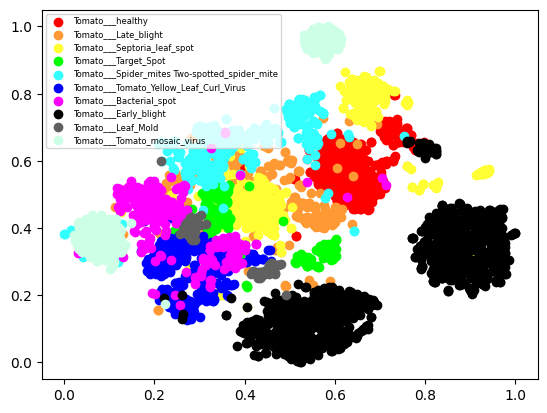

In [ ]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
colors_per_class = {
    0 : [255, 0, 0],
    1 : [255, 153, 51],
    2 : [255, 255, 51],
    3 : [0, 255, 0],
    4 : [51, 255, 255],
    5 : [0, 0, 255],
    6 : [255, 0, 255],
    7 : [0, 0, 0],
    8 : [96, 96, 96],
    9 : [204, 255, 229]
}
classes = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float32) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, color=color, label=classes[label])
# build a legend using the labels we set previously
ax.legend(loc='best', prop={'size': 6})